In [1]:
import os
import sys

import torch
import numpy as np
import pandas as pd

from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

# get the current script's directory
current_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
# get the parent directory
parent_directory = os.path.dirname(current_directory)
# add the parent directory to the sys.path
sys.path.append(parent_directory)

from optimization import functions
from optimization.updater import Updater

from utils import constants, common
from utils.config import Config
from utils.dataset_loader import PolicyDatasetLoader

from models.policy_model import RobotPolicy
from models.reward_model import RewardFunction

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
current_path = os.getcwd()
parent_path = os.path.dirname(current_path)
grand_parent_path = os.path.dirname(parent_path)

In [4]:
results_path = os.path.join(grand_parent_path, "results")

In [5]:
dataset_path = os.path.join(grand_parent_path, "dataset")
demo_path = os.path.join(dataset_path, "human_demonstrations")

In [6]:
# collected dataset folder name in ("dataset \\ human_demonstrations \\ collection_date")
collection_date = "2024_01_23" # year_month_day

In [7]:
dataset_folder = os.path.join(demo_path, collection_date)

In [8]:
json_files = os.listdir(dataset_folder + "\\jsons")

In [9]:
column_names = constants.COLUMN_NAMES

In [10]:
configs = Config()
# call the parameters method to set the parameters
configs.parameters()

Current Time:  Feb_11_2024-17_03_23


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training Device: ", device)
configs.device = device

configs = functions.setup_config(device=device)

Training Device:  cpu
Current Time:  Feb_11_2024-17_03_23


In [12]:
policy_model_directory = os.path.join(results_path,
                               "policy_network_params")

if not os.path.exists(policy_model_directory):
    os.makedirs(policy_model_directory)

In [13]:
policy_saving_path, reward_saving_path = functions.create_directories(configs=configs,
                                                                      results_path=results_path,
                                                                      saving_policy=True,
                                                                      saving_reward=True)

In [14]:
json_paths_train, results_path = functions.get_directories(parent_directory=parent_directory,
                                                     data_folder_name=constants.DEMO_COLLECTION_DATE) # DEMO_COLLECTION_DATE, TEST_COLLECTION_DATE

In [15]:
training_data = PolicyDatasetLoader(demo_data_json_paths=json_paths_train)


================== Policy Dataset Loader ==================

Number of Trajectories:  43
Each Trajectory Length:  30
Full Demo Dataset Size:  1379


In [16]:
train_loader = torch.utils.data.DataLoader(training_data,
                                           batch_size=configs.batch_size,
                                           shuffle=configs.data_shuffle,
                                           num_workers=configs.num_workers)

In [17]:
trajectory_indices = functions.find_indices_of_trajectory_changes(dataset=training_data)

In [18]:
policy_network = RobotPolicy(state_size=configs.state_size,
                             hidden_size=configs.hidden_size,
                             out_size=configs.action_size,
                             log_std_min=configs.policy_log_std_min,
                             log_std_max=configs.policy_log_std_max,
                             log_std_init=configs.policy_log_std_init,
                             device=configs.device)
    
reward_network = RewardFunction(state_action_size=configs.state_action_size,
                                hidden_size=configs.hidden_size,
                                out_size=configs.reward_size,
                                device=configs.device)

In [19]:
updater_obj = Updater(configs=configs,
                      policy_network=policy_network,
                      reward_network=reward_network)
updater_obj.initialize_optimizers()

In [20]:
mean_rewards = []
mean_loss_reward = []
mean_loss_policy = []
EPISODES_TO_PLAY = 1
REWARD_FUNCTION_UPDATE = 10
DEMO_BATCH = 100
sample_trajs = []

In [21]:
D_demo, D_samp = np.array([]), np.array([])

In [22]:
demo_traj_list = []

In [23]:
for traj_start_index in range(len(trajectory_indices)):
    
    traj_df, reward_values_demo_data, reward_values_estim_data, logprob_action_estim_avg = \
        functions.get_estimated_rewards(configs=configs,
                                        updater_obj=updater_obj,
                                        data_loader=training_data,
                                        policy_network=updater_obj.policy_network,
                                        reward_network=updater_obj.reward_network,
                                        trajectory_indices=trajectory_indices,
                                        traj_start_index=traj_start_index,
                                        is_inference_reward=False,
                                        is_inference_policy=False)
    demo_traj_list.append(traj_df)
    del traj_df

In [24]:
def preprocess_traj(traj_list, step_list, is_Demo=False):
    step_list = step_list.tolist()
    
    for traj_df in traj_list:
        
        if is_Demo:
        
            states = traj_df[["state_label_norm_1", "state_label_norm_2", "state_label_norm_3"]].values
            actions = traj_df[["action_label_norm_1", "action_label_norm_2", "action_label_norm_3"]].values
            next_states = traj_df[["next_state_label_norm_1", "next_state_label_norm_2", "next_state_label_norm_3"]].values
            probs = np.ones((actions.shape[0], actions.shape[1]))
        
        else:
            states = np.array([state_tensor[0].numpy() for state_tensor in traj_df[0]])
            actions = np.array([action_tensor.clone().detach()[0].numpy() for action_tensor in traj_df[1]])
            probs = np.array([prob_tensor.clone().detach()[0].numpy() for prob_tensor in traj_df[2]])
            rewards = np.array([reward_tensor.clone().detach()[0].numpy() for reward_tensor in traj_df[3]])
        
        x = np.concatenate((states, probs, actions), axis=1)
        step_list.extend(x)
    
    return np.array(step_list)

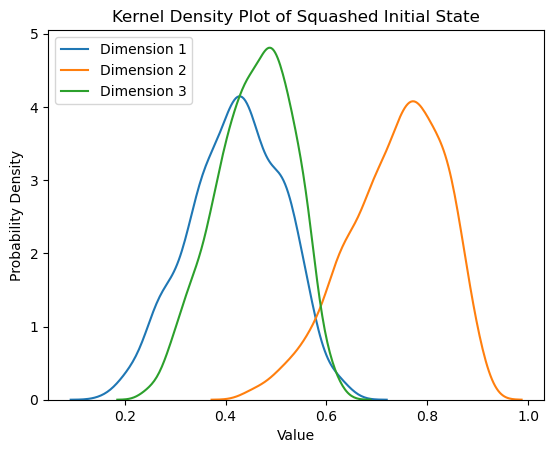

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def squash_to_range(x, min_value, max_value):
    return 1 / (1 + np.exp(-x)) * (max_value - min_value) + min_value

def squash_fun(x, min_value, max_value):
    return 0.5 * (x + 1) * (max_value - min_value) + min_value

# Define initial state means and variances
initial_state_means = [0.3, 0.8, 0.4]
initial_state_variances = [0.4, 0.5, 0.3]

# Define specific ranges for squashing
min_ranges = [0.05, 0.30, 0.10]
max_ranges = [0.70, 0.95, 0.70]

# Generate random samples for the initial state
state_0_rand = np.random.normal(loc=initial_state_means, scale=np.sqrt(initial_state_variances), size=(1000, len(initial_state_means)))

# Squash the random samples to the specified ranges
state_0_squashed = np.zeros_like(state_0_rand)
for i in range(len(initial_state_means)):
    state_0_squashed[:, i] = squash_to_range(x=state_0_rand[:, i], min_value=min_ranges[i], max_value=max_ranges[i])

# Plot the squashed values
for i in range(len(initial_state_means)):
    sns.kdeplot(state_0_squashed[:, i], label=f'Dimension {i + 1}')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Kernel Density Plot of Squashed Initial State')

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [26]:
def generate_initial_rand_state():
    
    def squash_to_range(x, min_value, max_value):
        return 1 / (1 + np.exp(-x)) * (max_value - min_value) + min_value

    # Define initial state means and variances
    initial_state_means = [0.3, 0.8, 0.4]
    initial_state_variances = [0.4, 0.5, 0.3]
    
    # Define specific ranges for squashing
    min_ranges = [0.05, 0.30, 0.10]
    max_ranges = [0.70, 0.95, 0.70]
    
    # Generate random samples for the initial state
    state_0_rand = np.random.normal(loc=initial_state_means, scale=np.sqrt(initial_state_variances), size=(1, len(initial_state_means)))

    # Squash the random samples to the specified ranges
    state_0_squashed = np.zeros_like(state_0_rand)
    for i in range(len(initial_state_means)):
        state_0_squashed[:, i] = squash_to_range(x=state_0_rand[:, i], min_value=min_ranges[i], max_value=max_ranges[i])

    return state_0_squashed

In [52]:
def generate_session(t_max, updater_obj):
    
    states, traj_probs, actions, rewards = [], [], [], []
    
    state_0 = generate_initial_rand_state()
    s = torch.Tensor(state_0)
    
    q_t = 1.0

    for t in range(t_max):
        output_action_norm, action_std, action_log_prob, action_entropy, action_mu_and_std, action_dist = \
            updater_obj.policy_network.estimate_action(state=s,
                                                       is_inference=False)

        action_probs = torch.exp(action_log_prob)
        a = output_action_norm

        output_action_denorm = common.denormalize_action(action_norm=output_action_norm.clone().detach().numpy(),
                                                         norm_range_list=training_data.action_norms)

        if output_action_denorm[0][-1] < -constants.ROBOT_BASE_HEIGHT:
            done = True
        else:
            done = False
        
        norm_state_estim_df = pd.DataFrame(s)
        norm_action_estim_df = pd.DataFrame(output_action_norm.clone().detach())

        state_action_estim_df = pd.concat([norm_state_estim_df, norm_action_estim_df], axis=1)
        state_action_estim_tensor = torch.tensor(state_action_estim_df.values.astype(np.float64), dtype=torch.float64, device=configs.device)
        reward_values_tensor = updater_obj.reward_network.estimate_reward(state_action=state_action_estim_tensor.float(),
                                                                          is_inference=False)

        r = reward_values_tensor

        next_state_denorm = functions.calculate_next_state(action_denorm=output_action_denorm[0],
                                                           obstacle_location=np.array(constants.OBSTACLE_LOCATION),
                                                           target_location=np.array(constants.TARGET_LOCATION))
        new_s = common.normalize_state(state=next_state_denorm,
                                                 norm_value_list=training_data.state_norms)
        
        q_t *= action_probs
        
        states.append(s)
        traj_probs.append(q_t.clone().requires_grad_(True))
        actions.append(a)
        rewards.append(r)
        
        s = torch.Tensor(np.array([new_s]))
        
        if done:
            print("DONE")
            break
    
    return states, actions, traj_probs, rewards

In [29]:
def get_cumulative_rewards(rewards, gamma=0.99):
    G = torch.zeros_like(rewards, dtype=torch.float32)

    G[-1] = rewards[-1]

    for idx in range(len(rewards) - 2, -1, -1):
        G[idx] = rewards[idx] + gamma * G[idx + 1]

    return G

In [30]:
def get_cumulative_returns(rewards, gamma):
    returns = torch.zeros_like(rewards)
    running_add = 0.0

    for t in reversed(range(len(rewards))):
        running_add = running_add * gamma + rewards[t]
        returns[t] = running_add

    # Normalize advantages
    normalized_returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    # Ensure the normalized_returns tensor has the same grad_fn as rewards
    cumulative_returns = normalized_returns.clone().detach().requires_grad_()

    return cumulative_returns

In [31]:
def policy_gradient_loss(log_probs, advantages, entropy_weight=1e-2):

#     normalized_advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-7)

    action_log_probs = log_probs.sum(dim=-1).unsqueeze(1)
    
    weighted_log_probs = action_log_probs * advantages

    entropy = -torch.mean(torch.sum(torch.exp(log_probs) * log_probs, dim=-1))
    
    loss = - torch.mean(weighted_log_probs) + entropy_weight * entropy
#     loss = - torch.mean(weighted_log_probs)

    return loss

# Tests

In [32]:
D_demo, D_samp = np.array([]), np.array([])

In [33]:
D_demo = preprocess_traj(traj_list=demo_traj_list, step_list=D_demo, is_Demo=True)

In [34]:
states, actions, traj_probs, rewards = generate_session(t_max=5, updater_obj=updater_obj)

In [35]:
EPISODES_TO_PLAY = 7
REWARD_FUNCTION_UPDATE = 5
NUM_EPOCHS = 200
DEMO_BATCH = 128
sample_trajs = []

In [36]:
for i in range(NUM_EPOCHS):
    
    t_max = constants.TRAJECTORY_SIZE
    trajs = [generate_session(t_max=t_max, updater_obj=updater_obj) for _ in range(EPISODES_TO_PLAY)]
    
    sample_trajs = trajs + sample_trajs
    
    D_samp = preprocess_traj(traj_list=trajs, step_list=D_samp, is_Demo=False)
    
    loss_reward, loss_policy = [], []
    is_early_stop = False
    
    for _ in range(REWARD_FUNCTION_UPDATE):
        selected_samp = np.random.choice(len(D_samp), DEMO_BATCH)
        selected_demo = np.random.choice(len(D_demo), DEMO_BATCH)
        
        D_s_samp = D_samp[selected_samp]
        D_s_demo = D_demo[selected_demo]
        
        D_s_samp = np.concatenate((D_s_demo, D_s_samp), axis=0)
        
        states, probs, actions = D_s_samp[:,:3], D_s_samp[:,3:6], D_s_samp[:,6:9]
        states_expert, actions_expert = D_s_demo[:,:3], D_s_demo[:,6:9]
        
        states = torch.tensor(states, dtype=torch.float32)
        probs = torch.tensor(probs, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        states_expert = torch.tensor(states_expert, dtype=torch.float32)
        actions_expert = torch.tensor(actions_expert, dtype=torch.float32)
        
        reward_samp_input = torch.cat((states, actions), axis=1)
        reward_demo_input = torch.cat((states_expert, actions_expert), axis=1)
        
        samp_rewards = updater_obj.reward_network.estimate_reward(state_action=reward_samp_input, is_inference=False)
        demo_rewards = updater_obj.reward_network.estimate_reward(state_action=reward_demo_input, is_inference=False)
        
        loss_IOC = -torch.mean(demo_rewards) + \
            torch.log(torch.mean(torch.exp(samp_rewards) / (torch.prod(probs, dim=1).unsqueeze(1) + 1e-7)))
        
        updater_obj.run_reward_optimizer(irl_loss=loss_IOC)
        
        loss_reward.append(loss_IOC.item())
        
        if torch.mean(demo_rewards) >= 0.99:
            is_early_stop = True
    
    for traj in trajs:
        states, actions, traj_probs, rewards = traj
        
        states_ = torch.cat(states, dim=0)
        actions_ = torch.stack(actions).squeeze(1).requires_grad_(True)
        traj_probs_ = torch.cat([prob.clone().detach().requires_grad_(True) for prob in traj_probs], dim=0)
        
        reward_samp_input_ = torch.cat((states_, actions_), axis=1)
        samp_rewards_ = updater_obj.reward_network.estimate_reward(state_action=reward_samp_input_, is_inference=True)
        
        cumulative_returns = get_cumulative_rewards(samp_rewards_, 0.99).to(torch.float32)
        
        loss_POL = policy_gradient_loss(log_probs=torch.log(traj_probs_),
                                        advantages=cumulative_returns)
        
        updater_obj.run_policy_optimizer(bc_loss=loss_POL)
        
        loss_policy.append(loss_POL.item())
    
    mean_loss_reward.append(np.mean(loss_reward))
    mean_loss_policy.append(np.mean(loss_policy))
    
    if i % 10 == 0:
        print("Avg. Reward : ", torch.mean(samp_rewards_).item())
        functions.save_reward(epoch=i,
                              reward_network=updater_obj.reward_network,
                              saving_path=reward_saving_path,
                              loss_value_str=str(abs(np.mean(loss_reward))).replace(".", "_"))
        functions.save_policy(epoch=i,
                              policy_network=updater_obj.policy_network,
                              saving_path=policy_saving_path,
                              loss_value_str=str(abs(np.mean(loss_policy))).replace(".", "_"))
    
    if is_early_stop:
        break

Avg. Reward :  0.497202068567276
Saved Reward Network Model: reward_network_epoch_1_loss_15_343892478942871.pt
Saved Policy Network Model: policy_network_epoch_1_loss_361_1559055873326.pt
Avg. Reward :  0.4192037284374237
Saved Reward Network Model: reward_network_epoch_11_loss_15_202100372314453.pt
Saved Policy Network Model: policy_network_epoch_11_loss_289_7284502301897.pt
Avg. Reward :  0.3438531458377838
Saved Reward Network Model: reward_network_epoch_21_loss_15_065132522583008.pt
Saved Policy Network Model: policy_network_epoch_21_loss_205_332271030971.pt
Avg. Reward :  0.2011798918247223
Saved Reward Network Model: reward_network_epoch_31_loss_14_902271270751953.pt
Saved Policy Network Model: policy_network_epoch_31_loss_151_98194994245256.pt
Avg. Reward :  0.1713835597038269
Saved Reward Network Model: reward_network_epoch_41_loss_14_781671905517578.pt
Saved Policy Network Model: policy_network_epoch_41_loss_117_97502626691546.pt
Avg. Reward :  0.13078704476356506
Saved Reward

In [53]:
updater_obj.policy_network = RobotPolicy(state_size=configs.state_size,
                                         hidden_size=configs.hidden_size,
                                         out_size=configs.action_size,
                                         log_std_min=configs.policy_log_std_min,
                                         log_std_max=configs.policy_log_std_max,
                                         log_std_init=configs.policy_log_std_init,
                                         device=configs.device)

In [54]:
additional_epochs = 300

for ep in range(additional_epochs):
    
    loss_policy = []
    
    t_max = constants.TRAJECTORY_SIZE
    trajs = [generate_session(t_max=t_max, updater_obj=updater_obj) for _ in range(EPISODES_TO_PLAY)]
    
    for traj in trajs:
        states, actions, traj_probs, rewards = traj
        
        states_ = torch.cat(states, dim=0)
        actions_ = torch.stack(actions).squeeze(1).requires_grad_()
        traj_probs_ = torch.cat([prob.clone().detach().requires_grad_(True) for prob in traj_probs], dim=0)
        
        reward_samp_input_ = torch.cat((states_, actions_), axis=1)
        samp_rewards_ = updater_obj.reward_network.estimate_reward(state_action=reward_samp_input_, is_inference=True)
        
        cumulative_returns = get_cumulative_rewards(samp_rewards_, 0.99).to(torch.float32)
        
        loss_POL = policy_gradient_loss(log_probs=torch.log(traj_probs_),
                                        advantages=cumulative_returns)
        
        updater_obj.run_policy_optimizer(bc_loss=loss_POL)
        
        loss_policy.append(loss_POL.item())
    
    mean_loss_policy.append(np.mean(loss_policy))

    print("Epoch : ", ep, " Avg. Reward : ", torch.mean(samp_rewards_).item())

state_0 :  [[0.5522644  0.86525286 0.39352354]]
state_0 :  [[0.39832694 0.67909165 0.46735774]]
state_0 :  [[0.60193736 0.60779736 0.43230437]]
state_0 :  [[0.32184823 0.76600699 0.4672333 ]]
state_0 :  [[0.30815185 0.57939184 0.55146863]]
state_0 :  [[0.38278099 0.51511931 0.42381973]]
state_0 :  [[0.56081562 0.60584042 0.45548221]]
Epoch :  0  Avg. Reward :  0.13242985308170319
state_0 :  [[0.26060984 0.75852327 0.53126015]]
state_0 :  [[0.49245964 0.79205776 0.47456862]]
state_0 :  [[0.43876556 0.6914906  0.49530128]]
state_0 :  [[0.40756695 0.66653581 0.44855273]]
state_0 :  [[0.43594105 0.74168445 0.4859847 ]]
state_0 :  [[0.461776   0.78267485 0.45898126]]
state_0 :  [[0.50503185 0.5472035  0.51565584]]
Epoch :  1  Avg. Reward :  0.030116451904177666
state_0 :  [[0.53052027 0.75227696 0.53210554]]
state_0 :  [[0.47114549 0.66120761 0.39549198]]
state_0 :  [[0.37758485 0.78560473 0.52295843]]
state_0 :  [[0.47865126 0.82220324 0.51445499]]
state_0 :  [[0.4922743  0.75157181 0.4791

state_0 :  [[0.24369481 0.60496    0.45236591]]
state_0 :  [[0.4994976  0.83507666 0.47296269]]
state_0 :  [[0.44565088 0.64205024 0.53884041]]
state_0 :  [[0.3799649  0.75510438 0.48402329]]
state_0 :  [[0.50754373 0.68252172 0.44245014]]
state_0 :  [[0.49372177 0.81020856 0.48389839]]
Epoch :  22  Avg. Reward :  0.06937537342309952
state_0 :  [[0.47852303 0.77992805 0.43756909]]
state_0 :  [[0.33259068 0.85840999 0.50461255]]
state_0 :  [[0.3210888  0.87326568 0.50150598]]
state_0 :  [[0.27113463 0.86781607 0.6049325 ]]
state_0 :  [[0.43637829 0.80793655 0.56180677]]
state_0 :  [[0.50424403 0.90144691 0.4644401 ]]
state_0 :  [[0.47089776 0.79260211 0.4174949 ]]
Epoch :  23  Avg. Reward :  0.09884308278560638
state_0 :  [[0.32774865 0.8237086  0.51043636]]
state_0 :  [[0.46555722 0.76314978 0.44607425]]
state_0 :  [[0.35767112 0.67835352 0.46980835]]
state_0 :  [[0.46820696 0.83326691 0.29024564]]
state_0 :  [[0.16343862 0.82339777 0.45616461]]
state_0 :  [[0.43883641 0.65798885 0.564

state_0 :  [[0.38324404 0.74944028 0.59751604]]
Epoch :  43  Avg. Reward :  0.07660670578479767
state_0 :  [[0.46911145 0.70310098 0.45867676]]
state_0 :  [[0.34799083 0.52710284 0.4794799 ]]
state_0 :  [[0.29902945 0.59039016 0.42210495]]
state_0 :  [[0.43193572 0.64998267 0.30704   ]]
state_0 :  [[0.55151995 0.80829403 0.61657736]]
state_0 :  [[0.42628016 0.62076697 0.53626869]]
state_0 :  [[0.47726829 0.83756915 0.5606321 ]]
Epoch :  44  Avg. Reward :  0.04578976333141327
state_0 :  [[0.41286097 0.75976615 0.49533654]]
state_0 :  [[0.34722742 0.6000328  0.60384167]]
state_0 :  [[0.53083025 0.76434537 0.45368285]]
state_0 :  [[0.40372457 0.80350096 0.29160649]]
state_0 :  [[0.38334122 0.89006785 0.41905139]]
state_0 :  [[0.54841564 0.74816328 0.42009038]]
state_0 :  [[0.45467896 0.84215956 0.47711188]]
Epoch :  45  Avg. Reward :  0.011416275054216385
state_0 :  [[0.39318737 0.79494354 0.30651477]]
state_0 :  [[0.38313835 0.76842821 0.3515149 ]]
state_0 :  [[0.42305313 0.78456631 0.38

state_0 :  [[0.32824296 0.76711368 0.35356758]]
Epoch :  65  Avg. Reward :  0.06913509964942932
state_0 :  [[0.51158561 0.76154088 0.52494974]]
state_0 :  [[0.38633524 0.82039408 0.40550324]]
state_0 :  [[0.34063051 0.76703251 0.50231846]]
state_0 :  [[0.46566529 0.77071901 0.56550557]]
state_0 :  [[0.49916907 0.83647436 0.38806277]]
state_0 :  [[0.36167025 0.72367035 0.43467569]]
state_0 :  [[0.43521785 0.76504212 0.44191961]]
Epoch :  66  Avg. Reward :  0.0585271380841732
state_0 :  [[0.44769176 0.74151033 0.5015753 ]]
state_0 :  [[0.44718634 0.65241321 0.4327444 ]]
state_0 :  [[0.3917767  0.77588101 0.58301558]]
state_0 :  [[0.49880008 0.51235047 0.37940797]]
state_0 :  [[0.35974971 0.56447446 0.5006852 ]]
state_0 :  [[0.37155301 0.73816167 0.46663411]]
state_0 :  [[0.3785     0.88998552 0.46646327]]
Epoch :  67  Avg. Reward :  0.10977652668952942
state_0 :  [[0.39823786 0.79324708 0.54887772]]
state_0 :  [[0.52269453 0.83798425 0.38987239]]
state_0 :  [[0.50105694 0.70475188 0.5208

state_0 :  [[0.42938953 0.64837868 0.52058169]]
state_0 :  [[0.32897668 0.65328067 0.41927719]]
state_0 :  [[0.43776272 0.86584292 0.46058838]]
Epoch :  87  Avg. Reward :  0.012740069068968296
state_0 :  [[0.25625289 0.88773346 0.39118102]]
state_0 :  [[0.43018703 0.87743757 0.29409534]]
state_0 :  [[0.42340978 0.92587161 0.49248787]]
state_0 :  [[0.57793941 0.76633017 0.3712046 ]]
state_0 :  [[0.60427687 0.69104177 0.44031297]]
state_0 :  [[0.33889142 0.63407439 0.50500817]]
state_0 :  [[0.25907442 0.71465263 0.45751022]]
Epoch :  88  Avg. Reward :  0.0488312728703022
state_0 :  [[0.47981124 0.82310109 0.51062103]]
state_0 :  [[0.47881975 0.68363385 0.44744155]]
state_0 :  [[0.38503283 0.84569555 0.58486271]]
state_0 :  [[0.45095444 0.74960831 0.5019817 ]]
state_0 :  [[0.31534584 0.59345555 0.4892598 ]]
state_0 :  [[0.42700089 0.89724142 0.48769491]]
state_0 :  [[0.51646977 0.80909166 0.4009297 ]]
Epoch :  89  Avg. Reward :  0.037722837179899216
state_0 :  [[0.49322724 0.79467387 0.33

Epoch :  109  Avg. Reward :  0.051624737679958344
state_0 :  [[0.48920067 0.78931616 0.58363426]]
state_0 :  [[0.35647825 0.81482273 0.3989922 ]]
state_0 :  [[0.34412325 0.75366861 0.37549529]]
state_0 :  [[0.3084276  0.67629271 0.533789  ]]
state_0 :  [[0.28811453 0.83383095 0.5707197 ]]
state_0 :  [[0.47770736 0.74850296 0.47815028]]
state_0 :  [[0.37158691 0.81659702 0.40052303]]
Epoch :  110  Avg. Reward :  0.09792663902044296
state_0 :  [[0.37324502 0.89470361 0.49403807]]
state_0 :  [[0.4748982  0.90463395 0.30159947]]
state_0 :  [[0.36787519 0.80024988 0.45147225]]
state_0 :  [[0.55519205 0.78015831 0.36358749]]
state_0 :  [[0.42641392 0.72599724 0.48886426]]
state_0 :  [[0.30149865 0.64200506 0.48325634]]
state_0 :  [[0.48843738 0.79894057 0.48391018]]
Epoch :  111  Avg. Reward :  0.0750124529004097
state_0 :  [[0.38116452 0.63403905 0.44285246]]
state_0 :  [[0.32206805 0.67027958 0.3709327 ]]
state_0 :  [[0.41316962 0.76928727 0.54578563]]
state_0 :  [[0.36956727 0.81916636 0.

state_0 :  [[0.4865418  0.56276162 0.45542089]]
state_0 :  [[0.37024118 0.71811284 0.38041516]]
state_0 :  [[0.21760646 0.7748797  0.37947224]]
state_0 :  [[0.3270387  0.70271381 0.43697631]]
Epoch :  132  Avg. Reward :  0.04145359620451927
state_0 :  [[0.54793383 0.70999837 0.38494801]]
state_0 :  [[0.31994146 0.84364995 0.41377202]]
state_0 :  [[0.30620843 0.83445559 0.36964746]]
state_0 :  [[0.3157617  0.50233985 0.53675401]]
state_0 :  [[0.31321416 0.73374752 0.55059002]]
state_0 :  [[0.41513896 0.70553676 0.48712595]]
state_0 :  [[0.37532021 0.79428052 0.48954347]]
Epoch :  133  Avg. Reward :  0.09506881237030029
state_0 :  [[0.48509742 0.59827824 0.52972071]]
state_0 :  [[0.40126149 0.54769581 0.53344149]]
state_0 :  [[0.43780208 0.72631384 0.46364158]]
state_0 :  [[0.35144104 0.82657883 0.42598056]]
state_0 :  [[0.45347168 0.74104384 0.39486194]]
state_0 :  [[0.52723952 0.75081282 0.50160963]]
state_0 :  [[0.48864741 0.78176074 0.4295718 ]]
Epoch :  134  Avg. Reward :  0.1026067

state_0 :  [[0.49673301 0.7153572  0.42314436]]
Epoch :  153  Avg. Reward :  0.026067329570651054
state_0 :  [[0.57685064 0.67067563 0.43745324]]
state_0 :  [[0.18734844 0.514798   0.40691608]]
state_0 :  [[0.54264506 0.83157269 0.36299127]]
state_0 :  [[0.37976013 0.67401633 0.49813164]]
state_0 :  [[0.46346511 0.74271016 0.50405869]]
state_0 :  [[0.54643144 0.8679871  0.48488154]]
state_0 :  [[0.38362653 0.80097365 0.35742278]]
Epoch :  154  Avg. Reward :  0.0030566647183150053
state_0 :  [[0.44593454 0.82284636 0.29133446]]
state_0 :  [[0.3042483  0.53070274 0.52963137]]
state_0 :  [[0.38725006 0.81141857 0.37968531]]
state_0 :  [[0.35599267 0.7511449  0.52002528]]
state_0 :  [[0.462166   0.79509892 0.32320854]]
state_0 :  [[0.47630776 0.61559614 0.51197601]]
state_0 :  [[0.36991963 0.78673907 0.33125034]]
Epoch :  155  Avg. Reward :  0.023672545328736305
state_0 :  [[0.53908806 0.60603598 0.43931823]]
state_0 :  [[0.33307002 0.83349424 0.38484953]]
state_0 :  [[0.27158283 0.5849647

state_0 :  [[0.30489519 0.59218052 0.49873001]]
state_0 :  [[0.34843345 0.87678809 0.30266967]]
state_0 :  [[0.38753705 0.80863897 0.48562653]]
state_0 :  [[0.59226257 0.73067531 0.41146129]]
state_0 :  [[0.47074799 0.78364848 0.43791214]]
Epoch :  175  Avg. Reward :  0.0844339057803154
state_0 :  [[0.50046572 0.58030852 0.38772148]]
state_0 :  [[0.36718308 0.67721963 0.50321087]]
state_0 :  [[0.44055013 0.62907476 0.37348607]]
state_0 :  [[0.40442989 0.67827618 0.505455  ]]
state_0 :  [[0.36062684 0.76204827 0.4067455 ]]
state_0 :  [[0.42805227 0.82217953 0.5548927 ]]
state_0 :  [[0.46555807 0.56536824 0.34293235]]
Epoch :  176  Avg. Reward :  0.019975248724222183
state_0 :  [[0.35672435 0.6551205  0.3424735 ]]
state_0 :  [[0.54905041 0.60771806 0.56391816]]
state_0 :  [[0.45734373 0.87363078 0.40586356]]
state_0 :  [[0.46886102 0.69818115 0.40246398]]
state_0 :  [[0.52339185 0.71322477 0.54487971]]
state_0 :  [[0.56916749 0.81032494 0.56489932]]
state_0 :  [[0.56380584 0.74761572 0.4

state_0 :  [[0.34105013 0.84191955 0.4530874 ]]
state_0 :  [[0.38149487 0.69474831 0.49099102]]
Epoch :  196  Avg. Reward :  0.12805111706256866
state_0 :  [[0.42648824 0.69663921 0.36687488]]
state_0 :  [[0.41685107 0.72387749 0.42722398]]
state_0 :  [[0.55779637 0.6818329  0.47766708]]
state_0 :  [[0.49700766 0.80814913 0.41840998]]
state_0 :  [[0.57024217 0.81113783 0.46812607]]
state_0 :  [[0.55615039 0.78609922 0.51644491]]
state_0 :  [[0.46534338 0.78067587 0.44697446]]
Epoch :  197  Avg. Reward :  0.05903808772563934
state_0 :  [[0.36083115 0.79243811 0.48432111]]
state_0 :  [[0.35989017 0.70910074 0.3185419 ]]
state_0 :  [[0.49653011 0.67932035 0.51770505]]
state_0 :  [[0.59609162 0.67308447 0.43547706]]
state_0 :  [[0.36201886 0.75507339 0.44130051]]
state_0 :  [[0.30174356 0.82595824 0.40289531]]
state_0 :  [[0.33448902 0.64342482 0.46125236]]
Epoch :  198  Avg. Reward :  0.0919916108250618
state_0 :  [[0.40209825 0.66792488 0.56975475]]
state_0 :  [[0.45855768 0.62652729 0.4

state_0 :  [[0.47909859 0.77572762 0.57596521]]
state_0 :  [[0.43179417 0.76433226 0.42223137]]
state_0 :  [[0.30201523 0.80768736 0.53218346]]
state_0 :  [[0.46079982 0.79665179 0.48446908]]
state_0 :  [[0.53519172 0.65646843 0.46901995]]
state_0 :  [[0.5388261  0.90639139 0.5015494 ]]
Epoch :  219  Avg. Reward :  0.05866748467087746
state_0 :  [[0.22757384 0.52354256 0.37620436]]
state_0 :  [[0.42710799 0.69136732 0.46506292]]
state_0 :  [[0.52248647 0.8249155  0.36836568]]
state_0 :  [[0.43567692 0.87937674 0.39464419]]
state_0 :  [[0.34071701 0.8854012  0.54308212]]
state_0 :  [[0.39977091 0.60383426 0.46496246]]
state_0 :  [[0.42193051 0.69983512 0.47150909]]
Epoch :  220  Avg. Reward :  0.11049441248178482
state_0 :  [[0.34006339 0.7583873  0.40709165]]
state_0 :  [[0.48605549 0.84831217 0.35788183]]
state_0 :  [[0.33800587 0.78901503 0.51109751]]
state_0 :  [[0.48679446 0.77553819 0.48328452]]
state_0 :  [[0.45553888 0.60838033 0.53455751]]
state_0 :  [[0.28585598 0.74554399 0.4

state_0 :  [[0.58613861 0.68840831 0.36219694]]
state_0 :  [[0.40395947 0.76527075 0.46358283]]
Epoch :  240  Avg. Reward :  0.06294108182191849
state_0 :  [[0.44652463 0.86132597 0.28751158]]
state_0 :  [[0.43884943 0.62970524 0.38361609]]
state_0 :  [[0.45874385 0.41498572 0.30935816]]
state_0 :  [[0.53477954 0.62657624 0.43449487]]
state_0 :  [[0.42183246 0.85268389 0.24352831]]
state_0 :  [[0.51976802 0.75498757 0.52671184]]
state_0 :  [[0.52133809 0.83044633 0.44752636]]
Epoch :  241  Avg. Reward :  0.07209023833274841
state_0 :  [[0.21722678 0.6580143  0.46397395]]
state_0 :  [[0.36053459 0.62540294 0.36193084]]
state_0 :  [[0.3766065  0.68941526 0.47654376]]
state_0 :  [[0.4083606  0.67065099 0.4419733 ]]
state_0 :  [[0.46520918 0.75759513 0.53889961]]
state_0 :  [[0.52282049 0.68575576 0.44778624]]
state_0 :  [[0.39196366 0.47367336 0.38184085]]
Epoch :  242  Avg. Reward :  0.08940141648054123
state_0 :  [[0.31428978 0.58309288 0.38683666]]
state_0 :  [[0.3919297  0.75623714 0.

state_0 :  [[0.46643022 0.76966958 0.49149533]]
state_0 :  [[0.37024066 0.71910034 0.42259245]]
state_0 :  [[0.49489593 0.74747817 0.44994227]]
state_0 :  [[0.46688444 0.81439358 0.58392175]]
state_0 :  [[0.22827594 0.81371726 0.38699935]]
state_0 :  [[0.50908178 0.79451802 0.30467738]]
Epoch :  263  Avg. Reward :  0.11490897834300995
state_0 :  [[0.47101137 0.66164103 0.38952719]]
state_0 :  [[0.3522491  0.66787929 0.56125449]]
state_0 :  [[0.37487515 0.67002913 0.42984166]]
state_0 :  [[0.360575   0.71950053 0.47095074]]
state_0 :  [[0.27736243 0.62524708 0.5211629 ]]
state_0 :  [[0.47119427 0.82633592 0.44656665]]
state_0 :  [[0.55837466 0.85584406 0.49160985]]
Epoch :  264  Avg. Reward :  0.09704866260290146
state_0 :  [[0.32694689 0.70040996 0.31385043]]
state_0 :  [[0.27577817 0.73388139 0.48206463]]
state_0 :  [[0.4139375  0.76539673 0.4983428 ]]
state_0 :  [[0.34018663 0.55799736 0.53299974]]
state_0 :  [[0.20847976 0.72448213 0.54785373]]
state_0 :  [[0.5409616  0.79188634 0.5

state_0 :  [[0.34819008 0.68550555 0.42585105]]
state_0 :  [[0.26641753 0.6208887  0.46998757]]
state_0 :  [[0.27836148 0.83542502 0.59923213]]
state_0 :  [[0.43945478 0.73092656 0.50176253]]
Epoch :  285  Avg. Reward :  0.06568413227796555
state_0 :  [[0.48486997 0.64305915 0.39464962]]
state_0 :  [[0.5681146  0.87007147 0.27966825]]
state_0 :  [[0.51925318 0.67155715 0.35850786]]
state_0 :  [[0.30697367 0.8393903  0.51541398]]
state_0 :  [[0.43981057 0.79401436 0.51397136]]
state_0 :  [[0.30882281 0.86612622 0.41762322]]
state_0 :  [[0.25720101 0.75112545 0.42749348]]
Epoch :  286  Avg. Reward :  0.09372127801179886
state_0 :  [[0.32617004 0.7945126  0.51349176]]
state_0 :  [[0.45358442 0.8461037  0.46661758]]
state_0 :  [[0.51331404 0.83920363 0.43311602]]
state_0 :  [[0.41149975 0.81008646 0.51570775]]
state_0 :  [[0.40891549 0.80409487 0.38404393]]
state_0 :  [[0.64150995 0.77243631 0.46814681]]
state_0 :  [[0.27398561 0.85268335 0.48540683]]
Epoch :  287  Avg. Reward :  0.0587585

mean reward loss:14.57898432636261 loss: 14.327057838439941
mean policy loss:44.56172841719691 loss: 69.36891174316406


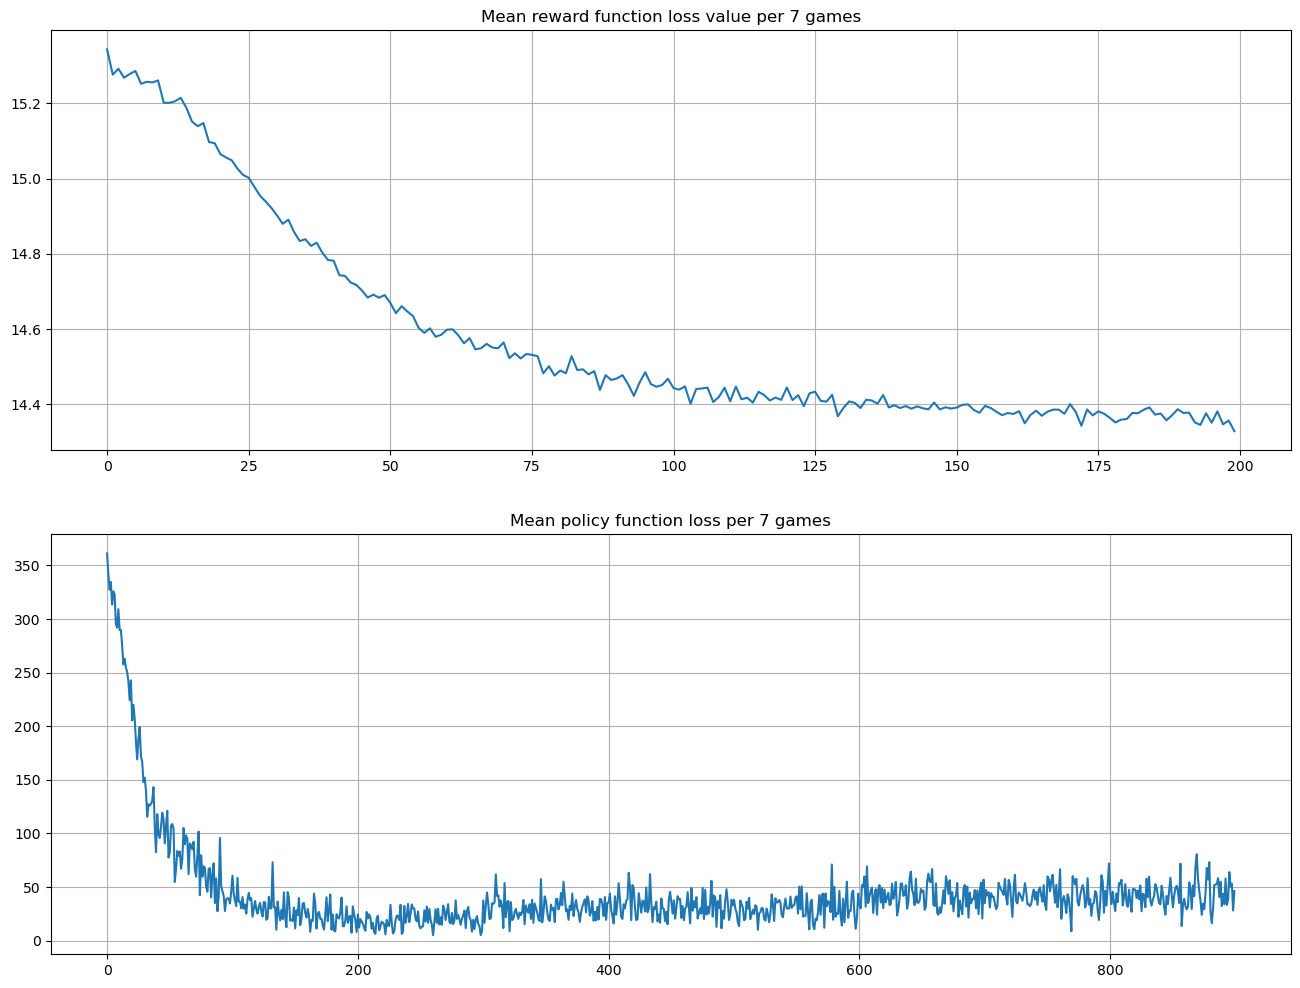

In [55]:
print(f"mean reward loss:{np.mean(mean_loss_reward)} loss: {loss_IOC.item()}")
print(f"mean policy loss:{np.mean(mean_loss_policy)} loss: {loss_POL.item()}")

plt.figure(figsize=[16, 12])
plt.subplot(2, 1, 1)
plt.title(f"Mean reward function loss value per {EPISODES_TO_PLAY} games")
plt.plot(mean_loss_reward)
plt.grid()

plt.subplot(2, 1, 2)
plt.title(f"Mean policy function loss per {EPISODES_TO_PLAY} games")
plt.plot(mean_loss_policy)
plt.grid()

plt.show()

# Evalutions

In [39]:
# for param in updater_obj.policy_network.parameters():
#     param.requires_grad = False
# updater_obj.policy_network = updater_obj.policy_network.eval()

In [40]:
test_trajectories = []

# loop through each separate trajectory inside the testing dataset
for traj_start_index in range(len(trajectory_indices)):
    
    traj_df, reward_values_demo_data, reward_values_estim_data, logprob_action_estim_avg = \
        functions.get_estimated_rewards(configs=configs,
                                        updater_obj=updater_obj,
                                        data_loader=training_data,
                                        policy_network=updater_obj.policy_network,
                                        reward_network=updater_obj.reward_network,
                                        trajectory_indices=trajectory_indices,
                                        traj_start_index=traj_start_index,
                                        is_inference_reward=True,
                                        is_inference_policy=True)
    
    # store outputs in the dataframe of trajectory information
    traj_df[constants.ACTION_PREDICTION_AVG_LOGPROB_NAME] = logprob_action_estim_avg.numpy().flatten()
    traj_df[constants.REWARD_DEMONSTRATION_TRAJECTORY_NAME] = reward_values_demo_data.numpy().flatten()
    traj_df[constants.REWARD_ROBOT_TRAJECTORY_NAME] = reward_values_estim_data.numpy().flatten()
    
    test_trajectories.append(traj_df)
    
    del traj_df

In [48]:
test_trajectories[-1]

,state_label_norm_1,state_label_norm_2,state_label_norm_3,state_label_denorm_1,state_label_denorm_2,state_label_denorm_3,action_label_norm_1,action_label_norm_2,action_label_norm_3,action_label_denorm_1,action_label_denorm_2,action_label_denorm_3,action_pred_logprob_1,action_pred_logprob_2,action_pred_logprob_3,action_pred_norm_1,action_pred_norm_2,action_pred_norm_3,action_pred_std_1,action_pred_std_2,action_pred_std_3,action_pred_denorm_1,action_pred_denorm_2,action_pred_denorm_3,trajectory_index,state_number,gnll_loss,state_est_norm_1,state_est_norm_2,state_est_norm_3,state_est_denorm_1,state_est_denorm_2,state_est_denorm_3,next_state_label_norm_1,next_state_label_norm_2,next_state_label_norm_3,next_state_label_denorm_1,next_state_label_denorm_2,next_state_label_denorm_3,next_state_est_norm_1,next_state_est_norm_2,next_state_est_norm_3,next_state_est_denorm_1,next_state_est_denorm_2,next_state_est_denorm_3,action_pred_avg_logprob,reward_demo_traj,reward_robot_traj
0,0.239584520459,0.549098074436,0.238536208868,0.718753561378,1.647294223309,0.715608626604,-0.282575041056,-0.349728494883,-0.452845662832,-0.565150022507,-0.699456930161,0.547154307365,-0.881266772747,-1.137652039528,-0.924057841301,-0.121989853680,-0.244937404990,0.148063555360,0.963029026985,1.244474649429,1.005132436752,-0.243979692459,-0.489874839783,1.148063540459,42,0,3.239186525345,0.239584520459,0.549098074436,0.238536208868,0.718753561378,1.647294223309,0.715608626604,0.239574017927,0.549095345797,0.238551435788,0.718722053781,1.647286037391,0.715654307365,0.261880206948,0.608649222071,0.438854513486,0.785640620844,1.825947666212,1.316563540459,-0.980992138386,0.821016073227,0.414590090513
1,0.239574044943,0.549095392227,0.238551437855,0.718722134829,1.647286176682,0.715654313564,-0.301822423935,-0.337225168943,-0.460428625345,-0.603644847870,-0.674450397491,0.539571404457,-0.882044434547,-1.127709150314,-0.942530155182,-0.132071286440,-0.245846703649,0.148059085011,0.963778197765,1.232162356377,1.023872137070,-0.264142513275,-0.491693377495,1.148059129715,42,1,3.246178627014,0.261880218983,0.608649194241,0.438854515553,0.785640656948,1.825947582722,1.316563546658,0.234890694936,0.542337008440,0.236023801486,0.704672084809,1.627011025321,0.708071404457,0.261007850833,0.608676777810,0.438853043238,0.783023552500,1.826030333431,1.316559129715,-0.984094619751,0.832296311855,0.228419035673
2,0.234890684485,0.542337000370,0.236023798585,0.704672053456,1.627011001110,0.708071395755,-0.332956850529,-0.306287735701,-0.449364006519,-0.665913701057,-0.612575531006,0.550635993481,-0.882027149200,-1.127734661102,-0.942520976067,-0.132070764899,-0.245862975717,0.148073464632,0.963761568069,1.232193708420,1.023862719536,-0.264141559601,-0.491725921631,1.148073434830,42,2,3.245973110199,0.261007845402,0.608676791191,0.438853055239,0.783023536205,1.826030373573,1.316559165716,0.222603332843,0.529386948224,0.239711997827,0.667809998530,1.588160844672,0.719135993481,0.261018335627,0.608687727932,0.438857811610,0.783055006881,1.826063183795,1.316573434830,-0.984094321728,0.854074060917,0.230642393231
3,0.222603321075,0.529386937618,0.239711999893,0.667809963226,1.588160812855,0.719135999680,-0.362390547991,-0.268660634756,-0.434770703316,-0.724781036377,-0.537321329117,0.565229296684,-0.882027149200,-1.127734184265,-0.942521572113,-0.132070690393,-0.245863169432,0.148073002696,0.963761568069,1.232193112373,1.023863315582,-0.264141321182,-0.491726398468,1.148072957993,42,3,3.245663166046,0.261018335819,0.608687698841,0.438857823610,0.783055007458,1.826063096523,1.316573470831,0.209317151556,0.514297032946,0.244576432228,0.627951454667,1.542891098839,0.733729296684,0.261018328641,0.608687727329,0.438857652664,0.783054985923,1.826063181988,1.316572957993,-0.984094321728,0.888439238071,0.230601370335
4,0.209317147732,0.514297008514,0.244576424360,0.627951443195,1.542891025543,0.733729273081,-0.381538033485,-0.232243731618,-0.422912865877,-0.763076066971,-0.464487433434,0.5770

In [42]:
# policy_network = RobotPolicy(state_size=configs.state_size,
#                              hidden_size=configs.hidden_size,
#                              out_size=configs.action_size,
#                              log_std_min=configs.policy_log_std_min,
#                              log_std_max=configs.policy_log_std_max,
#                              log_std_init=configs.policy_log_std_init,
#                              device=configs.device)

In [43]:
# bad_trajectories = []

# # loop through each separate trajectory inside the testing dataset
# for traj_start_index in range(len(trajectory_indices)):
    
#     traj_df, reward_values_demo_data, reward_values_estim_data, logprob_action_estim_avg = \
#         functions.get_estimated_rewards(configs=configs,
#                                         updater_obj=updater_obj,
#                                         data_loader=training_data,
#                                         policy_network=updater_obj.policy_network,
#                                         reward_network=updater_obj.reward_network,
#                                         trajectory_indices=trajectory_indices,
#                                         traj_start_index=traj_start_index,
#                                         is_inference_reward=True,
#                                         is_inference_policy=False)
    
#     # store outputs in the dataframe of trajectory information
#     traj_df[constants.ACTION_PREDICTION_AVG_LOGPROB_NAME] = logprob_action_estim_avg.numpy().flatten()
#     traj_df[constants.REWARD_DEMONSTRATION_TRAJECTORY_NAME] = reward_values_demo_data.numpy().flatten()
#     traj_df[constants.REWARD_ROBOT_TRAJECTORY_NAME] = reward_values_estim_data.numpy().flatten()
    
#     bad_trajectories.append(traj_df)
    
#     del traj_df

In [44]:
# bad_trajectories[-1]

In [45]:
# # load pretrained policy network parameters
# policy_loading_folder_name = constants.POLICY_LOADING_FOLDER
# policy_params_name = constants.POLICY_PARAMS_NAME
# policy_network = functions.load_policy_from_path(policy_network=updater_obj.policy_network,
#                                                  results_path=results_path,
#                                                  policy_loading_folder_name=policy_loading_folder_name,
#                                                  policy_params_name=policy_params_name)

# # set policy model to evaluation mode
# for param in policy_network.parameters():
#     param.requires_grad = False
# policy_network = policy_network.eval()

# policy_params_name

In [46]:
# good_trajectories = []

# # loop through each separate trajectory inside the testing dataset
# for traj_start_index in range(len(trajectory_indices)):
    
#     traj_df, reward_values_demo_data, reward_values_estim_data, logprob_action_estim_avg = \
#         functions.get_estimated_rewards(configs=configs,
#                                         updater_obj=updater_obj,
#                                         data_loader=training_data,
#                                         policy_network=policy_network,
#                                         reward_network=updater_obj.reward_network,
#                                         trajectory_indices=trajectory_indices,
#                                         traj_start_index=traj_start_index,
#                                         is_inference_reward=True,
#                                         is_inference_policy=True)
    
#     # store outputs in the dataframe of trajectory information
#     traj_df[constants.ACTION_PREDICTION_AVG_LOGPROB_NAME] = logprob_action_estim_avg.numpy().flatten()
#     traj_df[constants.REWARD_DEMONSTRATION_TRAJECTORY_NAME] = reward_values_demo_data.numpy().flatten()
#     traj_df[constants.REWARD_ROBOT_TRAJECTORY_NAME] = reward_values_estim_data.numpy().flatten()
    
#     good_trajectories.append(traj_df)
    
#     del traj_df

In [47]:
# good_trajectories[-1]